# Understanding the network through visualizations
During the training process, our models learn two things that allow it to generate the pseudo words. First, it creates a relevant embedded representation of the "vocabulary", the language's characters. Second, by leveraging these representations, it can generate an abstraction, a "memory", of the previously seen characters to create patterns which we ultimately analyze as syllables and plausible words. In this section, we will create visualizations of these two phenomenon to show that deep learning is not an absolute black box.

## 1 How characters relate to each other
The first layer of how model is an embedding layer, it contains the key to turn a character index into arrays of numbers, which is called embedding. We also need our tokenizer, which is a simple dictionary mapping the characters of our training dataset to their aforementioned indices.

In [4]:
%pip install 'numpy<2', torch scikit-learn seaborn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [267]:
import torch
import torch.nn as nn

# 0: redeclare the LSTMModel class
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim=4, hidden_dim=4, layers_number=1, char_to_idx={}, idx_to_char={}):
        super().__init__()
        vocab_size = len(char_to_idx.keys())
        self.char_to_idx = char_to_idx
        self.idx_to_char = idx_to_char
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, layers_number, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    # The forward function is the one getting called everytime
    # the model created by an instance of this class is called
    # model(x, hidden) == model.forward(x, hidden)
    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

# 1: load the model from the previous chapter
locale = "en-GB" # Change this variable if you want to inspect another language you trained
model = torch.load(f'locales/{locale}/lstm_model-{locale}.pth')
torch.set_grad_enabled(False)

# 2: extract the embedding layer and its associated characters
chars = [n if n != "\n" else "\\n" for n in model.idx_to_char.values()]
embedding = model.embedding.weight.numpy()

Now we will use the library scikit-learn's T-distributed Stochastic Neighbor Embedding (t-SNE) to do reduce the dimensionalities of the vectorial representation of the embedded characters. In our original model, the characters are represented in a 16 dimensional space, but to show how close the characters are associated to one another during the training process, we only need two dimensions.

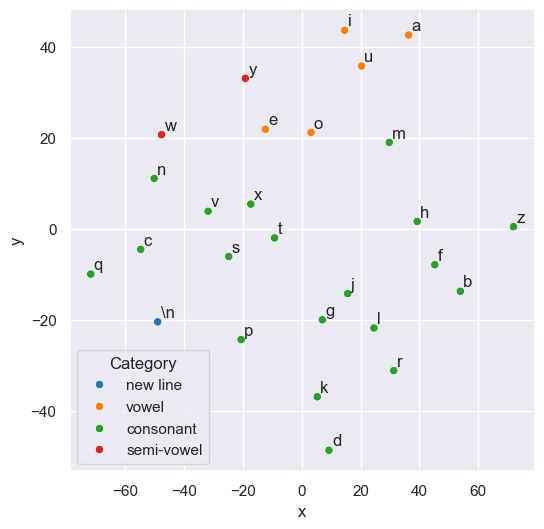

In [282]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 3 use scikit learn to do TSNE dimensionality reduction
X = np.array(embedding)
reduced_embedding = PCA(n_components=2).fit_transform(TSNE(n_components=2, perplexity=6).fit_transform(X))

df = pd.DataFrame(reduced_embedding, columns=["x", "y"])

df["chars"] = chars
df["Category"] = ["vowel" if c in "aeiou" else "semi-vowel" if c in "yw" else "new line" if c == "\\n" else "consonant" for c in chars]

plt.figure(figsize=(6, 6))
sns.scatterplot(x="x", y="y", data=df, hue="Category")

for i in range(len(chars)):
    plt.annotate(df["chars"][i], (df["x"][i]+1, df["y"][i]+1))

plt.show()

## 2 Inspecting the memory of an LSTM cell
This section is inspired by this [Andrej Karpathy's article](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

In [283]:
# 1 create a function that generated a pseudo-word
import torch.nn.functional as F
from spylls.hunspell import Dictionary

dictionary = Dictionary.from_files(f"locales/{locale}/{locale}")

def generate_pseudoword(model, length=3, start="", temperature=0.7):
    model.eval()
    # change these values if you change the number length of the hidden_dim in the model you saved in part 2
    hidden = (torch.zeros(1, 1 , 13),
                torch.zeros(1, 1 , 13))
    start_seq = [model.char_to_idx[n] for n in f"\n{start}"]
    inputs = torch.tensor(start_seq).unsqueeze(0)  # Shape: (1, seq_len)
    generated_seq = start_seq[1:]
    hidden_history = len(start)*[13*[1]]
    words_generated = []

    with torch.no_grad():
        while len(words_generated) < length:
            outputs, hidden = model(inputs, hidden)

            # outputs shape: (1, seq_len, vocab_size)
            # We need the last time step's output for the next prediction
            last_output = outputs[:, -1]  # Shape: (1, vocab_size)

            # Apply temperature scaling
            last_output = last_output / temperature
            probs = F.softmax(last_output, dim=-1).squeeze(0)  # the multinomial accepts only one order tensors

            # Ensure all the probabilities are valid
            if torch.isnan(probs).any() or torch.isinf(probs).any() or (probs < 0).any():
                print("Invalid probabilities detected. Resetting to uniform distribution.")
                probs = torch.ones_like(probs) / probs.size(0)

            # Sample the next character
            predicted_idx = torch.multinomial(probs, 1).item()
            generated_seq.append(predicted_idx)
            hidden_history.append(hidden[0].squeeze().numpy())
            inputs = torch.tensor([[predicted_idx]])  # Shape: (1, 1)

            if model.idx_to_char[predicted_idx] == "\n":
                new_word = ''.join([model.idx_to_char[i] for i in generated_seq[:-1]])
                generated_seq = []
                words_generated.append(new_word)
    return " ".join(words_generated)+" ", hidden_history

<Axes: >

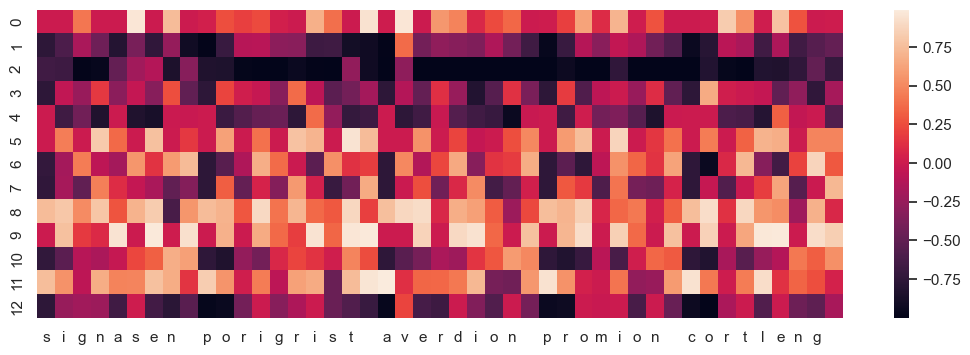

In [288]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2 have the function return a matrix of the successive hidden states along with the word
words, hidden_state_history = generate_pseudoword(model, length=5)

df = pd.DataFrame(hidden_state_history)

df = df.transpose()
df.columns = list(words)
# 3 create a second function that builds a heatmap with all values of the hidden state vector at each point of the generation
sns.set_theme(palette=None)

f, ax = plt.subplots(figsize=(13, 4))
sns.heatmap(df, annot=False, ax=ax)

In the beginning I thought this experiment was a failure and could explain this in one of two reasons. Either the hidden state vector is too large and the representation of the memory is too distributed to be associated to a single index, or the same vector is too short, and the model does not learn the pattern recognition enough to attempt any analysis in the first place.
But, as it turned out, I was using a set to collect the newly generated words in my original function. So that a word would not be generated twice. But this had as an effect to output the words in the wrong order... I then turn the set to a list in the generator function and was able to identify patterns in my LSTM cell.  

Below, we drop the other indices to highlight only the one that seemed to measure the length of a word, or more precisely, the chances for a word to finish. In the second word below, the chances a word ends might go down if a new character (chosen in a stochastic process) or sequence of character is an unlikely end for a word.

If you trick the number of parameters such as the `hidden_dim` or `embedding_dim` in the previous part, you might be able to identify an index that represent the likelihood of a vowel or a consonant being selected. In this model, with 13 dimension this aspect is too distributed in the vector, but with 8 dimensions, I could do it, although the words did not look as convincing.

<Axes: >

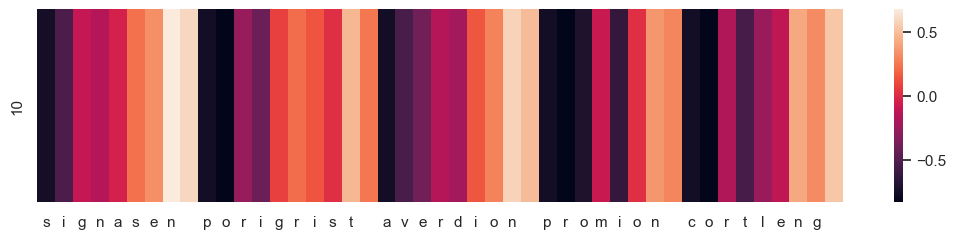

In [291]:
df_ = df.drop(df.index.to_list()[:10] + df.index.to_list()[11:])
f, ax = plt.subplots(figsize=(13, 2.5))
sns.heatmap(df_, annot=False, ax=ax)